# Lecture 4 - Confusion Matrix CART on CCHS

## Load the dataset

In [2]:
library(magrittr)

full_data <- epi7913A::cchs %>% dplyr::slice_sample(prop=0.1)
voutcome <- "CANHEARTbin"
head(full_data)

,age,sex,CANHEARTbin,householdsize,education,maritalstatus,immigration,houseincome
,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>
1,3,1,0,3,2,3,0,1
2,1,2,1,4,1,1,0,1
3,3,1,1,2,4,3,0,1
4,7,2,1,1,4,1,0,2
5,6,1,1,2,2,3,0,2
6,4,1,1,3,4,2,0,2


## Train, tune and test the model using 70/30 percent split data

In [3]:
# create train and test data
idx<-splitTools::partition(rep(0,nrow(full_data)), p=c(train=0.7, test=0.3), type="stratified")

train_data <- full_data[idx$train,]
test_data <- full_data[idx$test,]
 
# train a model with optimal hyperparameters
best_model<-sdgm::cart.bestmodel.bin(train_data, voutcome)
 
# predict on the test data; this is a generic predict function
preds<-predict(best_model, test_data)


 Best Parameters Found: 
Round = 9	minsplit = 7.0000	minbucket = 7.0000	cp = 0.02503666	maxdepth = 13.0000	Value = -0.6192534 


## Calculate the logloss on the test data and produce the confusion matric

In [4]:
# # logloss
if (!is.null(preds))
{
        test_logloss<- MLmetrics::LogLoss(preds, test_data[,voutcome] )
} else {
  test_logloss<-NA
  print("Logloss calculation failed because there are no predicted values")
}
 
print(caret::confusionMatrix(table(Pred=as.numeric(preds > 0.5), Actual=test_data[,voutcome]), positive="1"))

Confusion Matrix and Statistics

    Actual
Pred   0   1
   0  43  53
   1  73 131
                                          
               Accuracy : 0.58            
                 95% CI : (0.5219, 0.6365)
    No Information Rate : 0.6133          
    P-Value [Acc > NIR] : 0.89300         
                                          
                  Kappa : 0.0854          
                                          
 Mcnemar's Test P-Value : 0.09052         
                                          
            Sensitivity : 0.7120          
            Specificity : 0.3707          
         Pos Pred Value : 0.6422          
         Neg Pred Value : 0.4479          
             Prevalence : 0.6133          
         Detection Rate : 0.4367          
   Detection Prevalence : 0.6800          
      Balanced Accuracy : 0.5413          
                                          
       'Positive' Class : 1               
                                          


## Plot the resulting tree

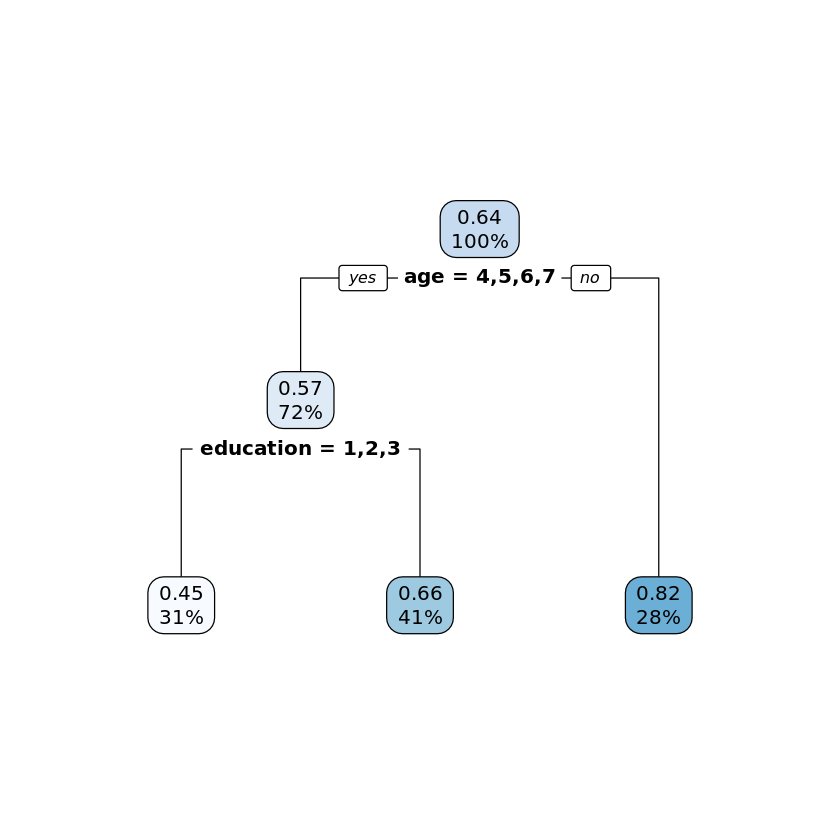

In [5]:
rpart.plot::rpart.plot(best_model$model,roundint=FALSE)


## The default decision threshold is 0.5, change that to 0.4

In [7]:
# set classification decision threshold value
classificationThreshold = 0.4

# obtain classification prediction scores
test.predictions <- as.factor(ifelse(predict(best_model$model, test_data)>classificationThreshold,1,0))

# calculate the confusion matrix
caret::confusionMatrix(table(Pred=test.predictions, Actual=test_data[,voutcome]),positive=1)


ERROR: Error in !all.equal(nrow(data), ncol(data)): invalid argument type


## Again, change the decision threshold to 0.6

In [8]:
# repeat for another threshold value
classificationThreshold = 0.6
test.predictions <- as.factor(ifelse(predict(best_model$model, test_data)>classificationThreshold,1,0))

caret::confusionMatrix(table(Pred=test.predictions, Actual=test_data[,voutcome]), positive="1")

Confusion Matrix and Statistics

    Actual
Pred   0   1
   0  82  80
   1  31 107
                                          
               Accuracy : 0.63            
                 95% CI : (0.5726, 0.6848)
    No Information Rate : 0.6233          
    P-Value [Acc > NIR] : 0.431           
                                          
                  Kappa : 0.2743          
                                          
 Mcnemar's Test P-Value : 5.215e-06       
                                          
            Sensitivity : 0.5722          
            Specificity : 0.7257          
         Pos Pred Value : 0.7754          
         Neg Pred Value : 0.5062          
             Prevalence : 0.6233          
         Detection Rate : 0.3567          
   Detection Prevalence : 0.4600          
      Balanced Accuracy : 0.6489          
                                          
       'Positive' Class : 1               
                                          

## To plot the Receiver Operating Characteristics (ROC) Curve

- ### First, obtain the prediction scores and align them to the labels (the outcomes).
- ### Also, you will need to sort the rows by decreasing values of **test.predictions**

In [9]:
test.predictions <- predict(best_model$model, test_data)
tmp <- cbind(test_data[,voutcome], test.predictions)
tmp <- tmp[order(test.predictions),]
head(tmp)

,,test.predictions
19,0,0.2068966
134,0,0.2068966
225,1,0.2068966
288,1,0.2068966
357,0,0.2068966
360,0,0.2068966


- ### Then, generate the ROC curve using the package **pROC**

In [10]:
roc <- pROC::roc(tmp[,1], tmp[,2])
head(roc)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$percent
[1] FALSE

$sensitivities
 [1] 1.00000000 0.97326203 0.93582888 0.86096257 0.82352941 0.79144385
 [7] 0.79144385 0.77005348 0.67379679 0.65240642 0.64171123 0.57219251
[13] 0.55614973 0.49732620 0.47593583 0.43850267 0.35828877 0.33689840
[19] 0.29946524 0.17647059 0.13368984 0.06951872 0.00000000

$specificities
 [1] 0.0000000 0.1238938 0.1769912 0.2477876 0.3008850 0.3628319 0.3982301
 [8] 0.4247788 0.5221239 0.5575221 0.6106195 0.7256637 0.7522124 0.7610619
[15] 0.8141593 0.8318584 0.8938053 0.9026549 0.9292035 0.9646018 0.9734513
[22] 0.9823009 1.0000000

$thresholds
 [1]      -Inf 0.2662390 0.3367037 0.3524845 0.3928571 0.4330357 0.4578804
 [8] 0.4798712 0.5046296 0.5464976 0.5720824 0.5938215 0.6324728 0.6614583
[15] 0.6742424 0.7026112 0.7530065 0.8163043 0.8552326 0.8766611 0.8988095
[22] 0.9419643       Inf

$direction
[1] "<"

$cases
      225       288       564       930       966        16       280       308 
0.2068966 0.2068966 0.2068966 0.2068966 0.2068966 0.3255814 0.3255814 0.3255814 
      353       403       610       928       166       207       336       433 
0.3255814 0.3255814 0.3255814 0.3255814 0.3478261 0.3478261 0.3478261 0.3478261 
      448       472       482       519       540       656       872       894 
0.3478261 0.3478261 0.3478261 0.3478261 0.3478261 0.3478261 0.3478261 0.3478261 
      909       964       125       129       195       522       833       868 
0.3478261 0.3478261 0.3571429 0.3571429 0.3571429 0.3571429 0.3571429 0.3571429 
      949       314       354       375       814       889       969       459 
0.3571429 0.4285714 0.4285714 0.4285714 0.4285714 0.4285714 0.4285714 0.4782609 
      598       658       915        95       139       191       237       282 
0.4782609 0.4782609 0.4782609 0.4814815 0.4814815 0.4814815 0.4814815 0.4814815 
      488       509       520       531       537       554       689       705 
0.4814815 0.4814815 0.4814815 0.4814815 0.4814815 0.4814815 0.4814815 0.4814815 
      710       729       782       932       984        93       410       634 
0.4814815 0.4814815 0.4814815 0.4814815 0.4814815 0.5277778 0.5277778 0.5277778 
      767       664       760        82        97       300       381       407 
0.5277778 0.5652174 0.5652174 0.5789474 0.5789474 0.5789474 0.5789474 0.5789474 
      569       743       795       851       908       971       976       994 
0.5789474 0.5789474 0.5789474 0.5789474 0.5789474 0.5789474 0.5789474 0.5789474 
      434       454       578        86       164       192       218       315 
0.6086957 0.6086957 0.6086957 0.6562500 0.6562500 0.6562500 0.6562500 0.6562500 
      358       464       497       764       807       832        43       378 
0.6562500 0.6562500 0.6562500 0.6562500 0.6562500 0.6562500 0.6666667 0.6666667 
      695       877        83       165       168       169       327       828 
0.6666667 0.6666667 0.6818182 0.6818182 0.6818182 0.6818182 0.6818182 0.6818182 
     1000        40        50       184       254       256       293       302 
0.6818182 0.7234043 0.7234043 0.7234043 0.7234043 0.7234043 0.7234043 0.7234043 
      303       370       707       753       759       837       879       881 
0.7234043 0.7234043 0.7234043 0.7234043 0.7234043 0.7234043 0.7234043 0.7234043 
      700       712       749       965        13        60       271       304 
0.7826087 0.7826087 0.7826087 0.7826087 0.8500000 0.8500000 0.8500000 0.8500000 
      427       580       813        29        77        92       128       141 
0.8500000 0.8500000 0.8500000 0.8604651 0.8604651 0.8604651 0.8604651 0.8604651 
      185       241       471       496       594       616       627       651 
0.8604651 0.8604651 0.8604651 0.8604651 0.8604651 0.8604651 0.8604651 0.8604651 
      701       778       794       824       863       864       883       897 
0.8604651 0.8604651 0.8604651 0.8604651 0.8604651 0.8604651 0.8604651 0.8604651 
      947       968       214       395       577       6

- ### Finally, plot the ROC curve

tmp
                0 0.206896551724138 0.325581395348837 0.347826086956522 
              113                19                13                22 
0.357142857142857 0.428571428571429            0.4375 0.478260869565217 
               13                13                 4                 7 
0.481481481481481 0.527777777777778 0.565217391304348 0.578947368421053 
               29                 8                 8                26 
0.608695652173913           0.65625 0.666666666666667 0.681818181818182 
                6                12                10                 9 
0.723404255319149 0.782608695652174              0.85  0.86046511627907 
               22                 5                10                27 
0.892857142857143 0.904761904761905 0.979166666666667                 1 
                9                13                15               187 

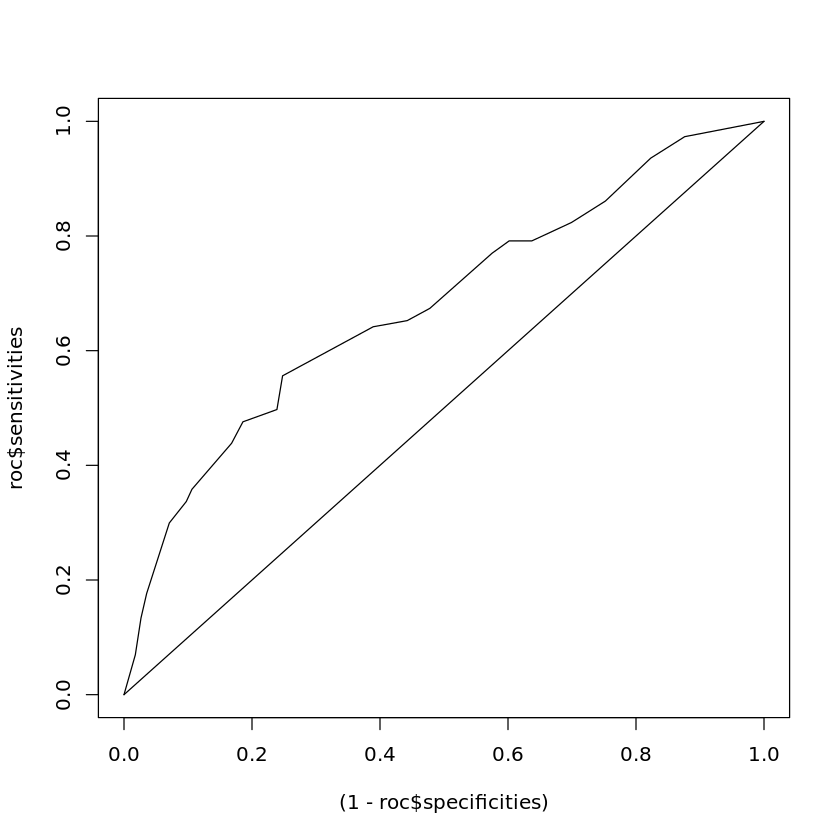

In [11]:
plot((1-roc$specificities), roc$sensitivities, type="l")
lines(c(0,1), c(0,1), type="l")
table(tmp)